In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt


In [286]:
def plot(df,name):
    # Your data
    column_name_probability = ['ProbabilityScalarArithmetic',
        'ProbabilityScalarLogic',
        'ProbabilityScalarMemory',
        'ProbabilityScalarBranch',
        'ProbabilityScalarJump',
        'ProbabilityVectorArithmetic',
        'ProbabilityVectorLogic',
        'ProbabilityVectorMemory',
        'ProbabilityVectorBranch',
        'ProbabilityVectorJump']
    
    column_name_probability_labels = ['ScalarArithmetic',
        'ScalarLogic',
        'ScalarMemory',
        'ScalarBranch',
        'ScalarJump',
        'VecArithmetic',
        'VecLogic',
        'VecMemory',
        'VecBranch',
        'VecJump']
    plt.figure(figsize=(14,14))

    plt.subplot(2, 2, 1)

    plt.title(name)
    x=range(0,len(column_name_probability))
    
    plt.bar(x=x,height=df[column_name_probability].mean(),alpha=0.3)
    plt.errorbar(x,df[column_name_probability].mean(),yerr=df[column_name_probability].std(), fmt='o')
    #.plot(kind='bar', width=0.8) # Plot bar chart
    #plt.title("ksad") # Set title as column name
    #plt.xlabel(column) # Set x-axis label as column name
    plt.xticks(ticks=x,labels=column_name_probability_labels,rotation=90-15,fontsize=8)
    #plt.xticks(ticks=range(0,len(column_name)),labels=column,rotation=45)
    plt.ylabel('Value') # Set y-axis label as 'Value'
    column_name=["SocketPower0", "SocketPower1","PSUPower0","PSUPower1"]
    plt.subplot(2, 2, 2)
    plt.title("System power")
    _ = plt.plot(df[column_name],label=column_name)
    plt.ylim([0,700])
    plt.legend()
    plt.subplot(2, 2, 3)
    filtered_df = df[column_name_probability].loc[:, df[column_name_probability].mean() > 0]
    plt.plot(filtered_df,label=filtered_df.columns.tolist())
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.title("System usage")
    plt.plot(df[["SystemCpuUsage" ,"ProcessCpuUsage"]],label=["SystemCpuUsage" ,"ProcessCpuUsage"])
    plt.legend()
    plt.savefig(f"{name}.png")

Opened file: power_copy.csv
Opened file: power_copy_mem.csv
Opened file: power_copy_mem_avx.csv
Opened file: power_daxpy_mem_avx_fma.csv
Opened file: power_load_avx.csv
Opened file: power_load_mem.csv
Opened file: power_peakflops_avx_fma.csv
Opened file: power_store_mem.csv
Opened file: power_store_mem_avx.csv
Opened file: power_stream_mem_avx_fma.csv
Opened file: power_update_avx.csv


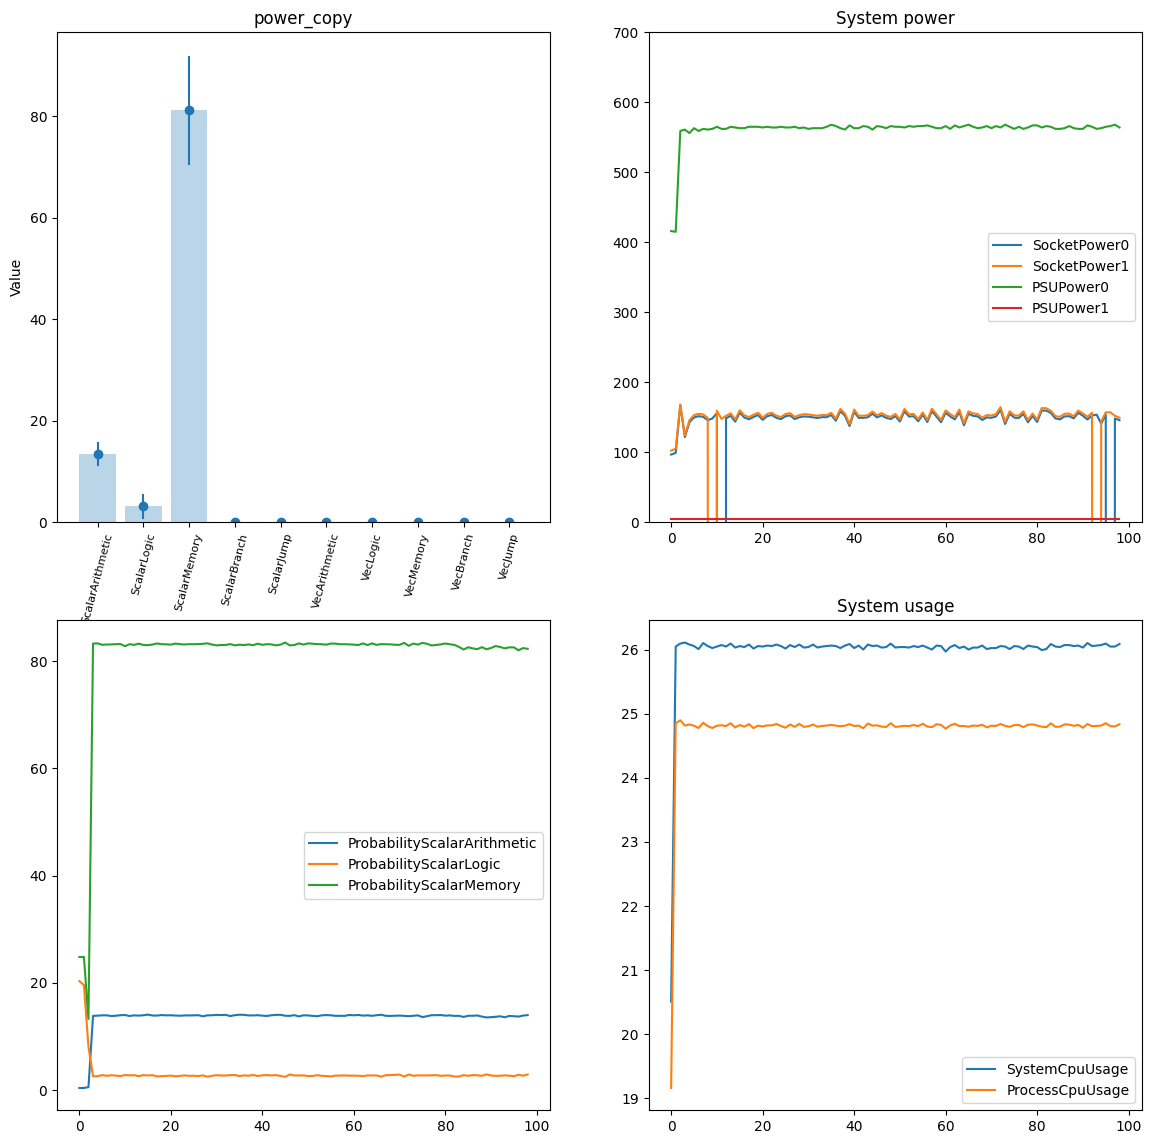

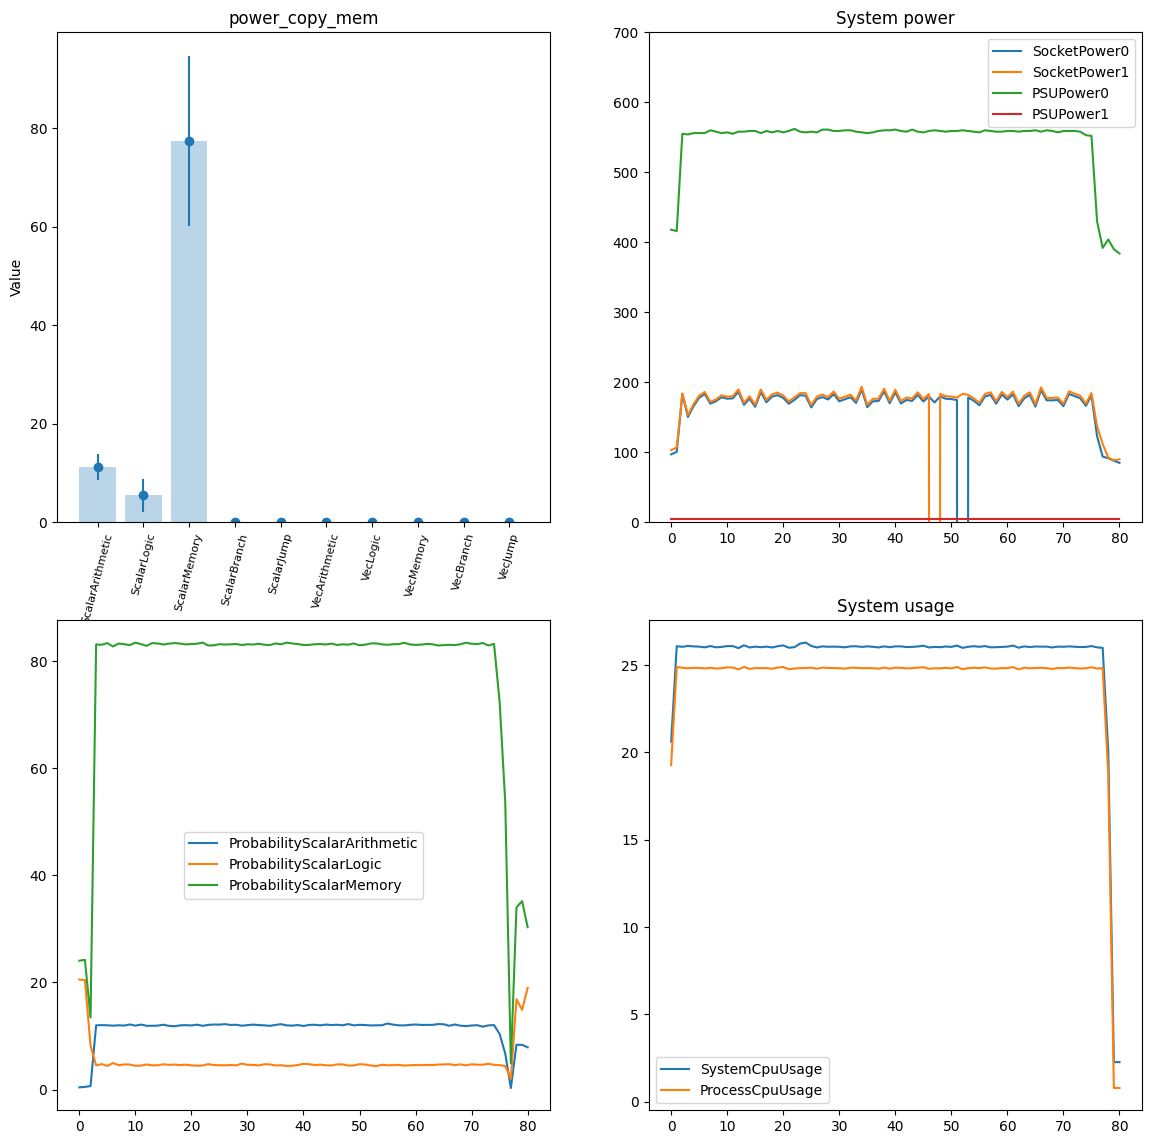

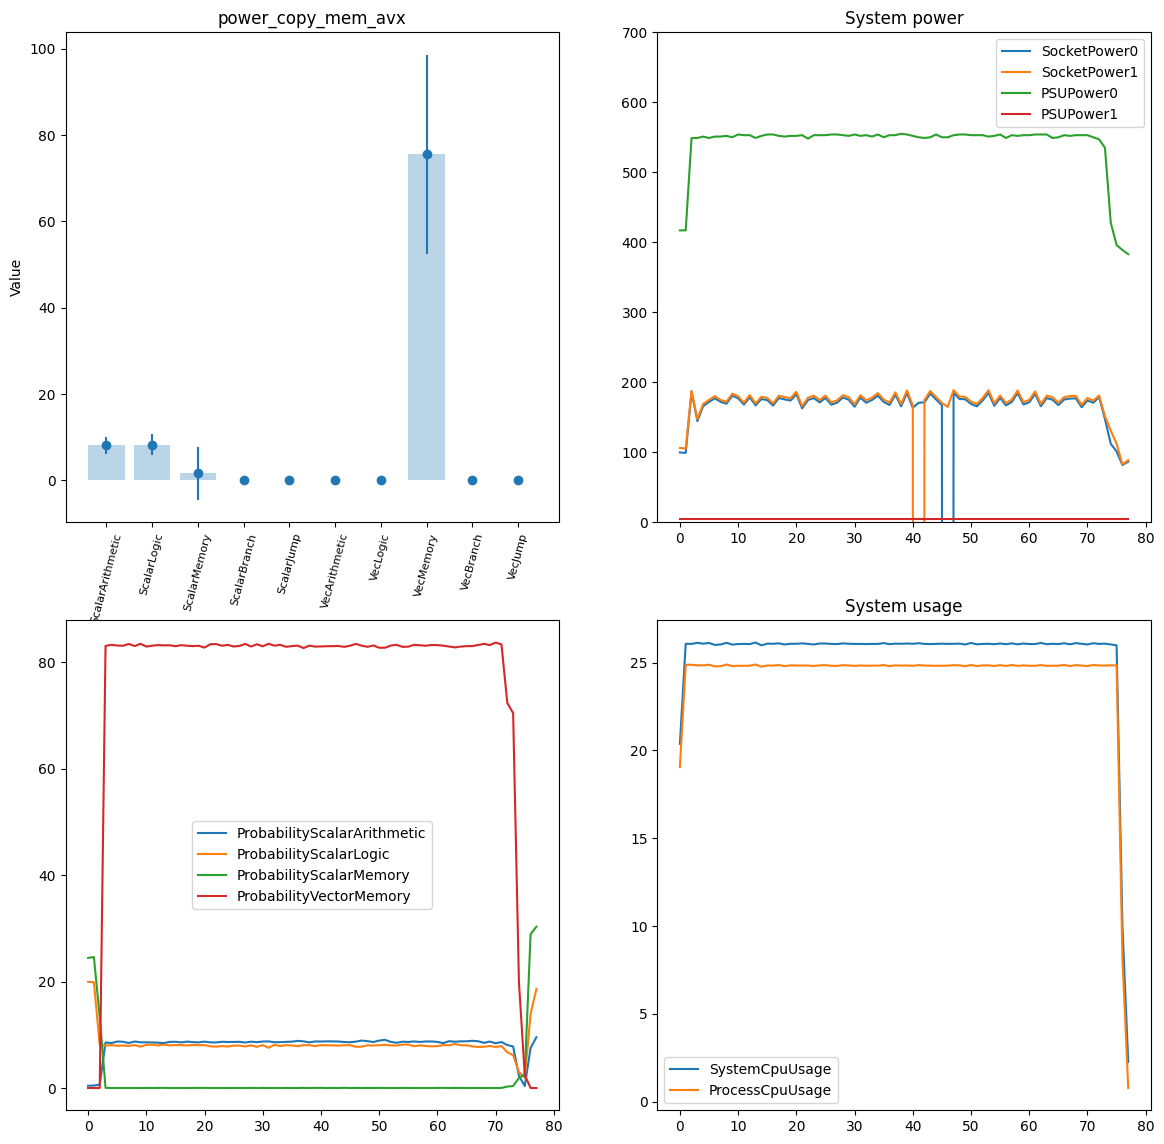

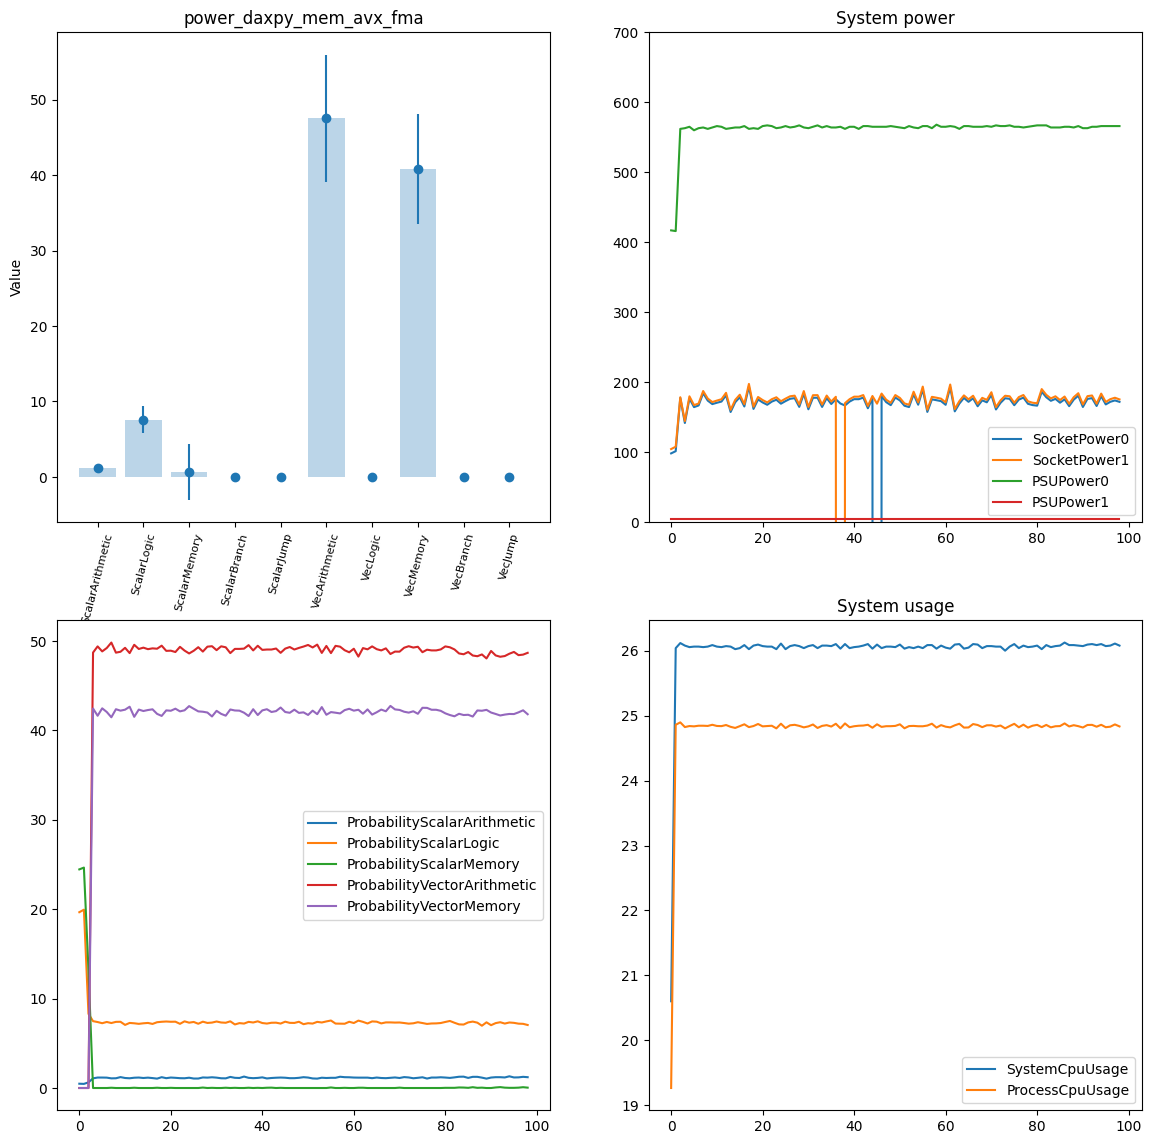

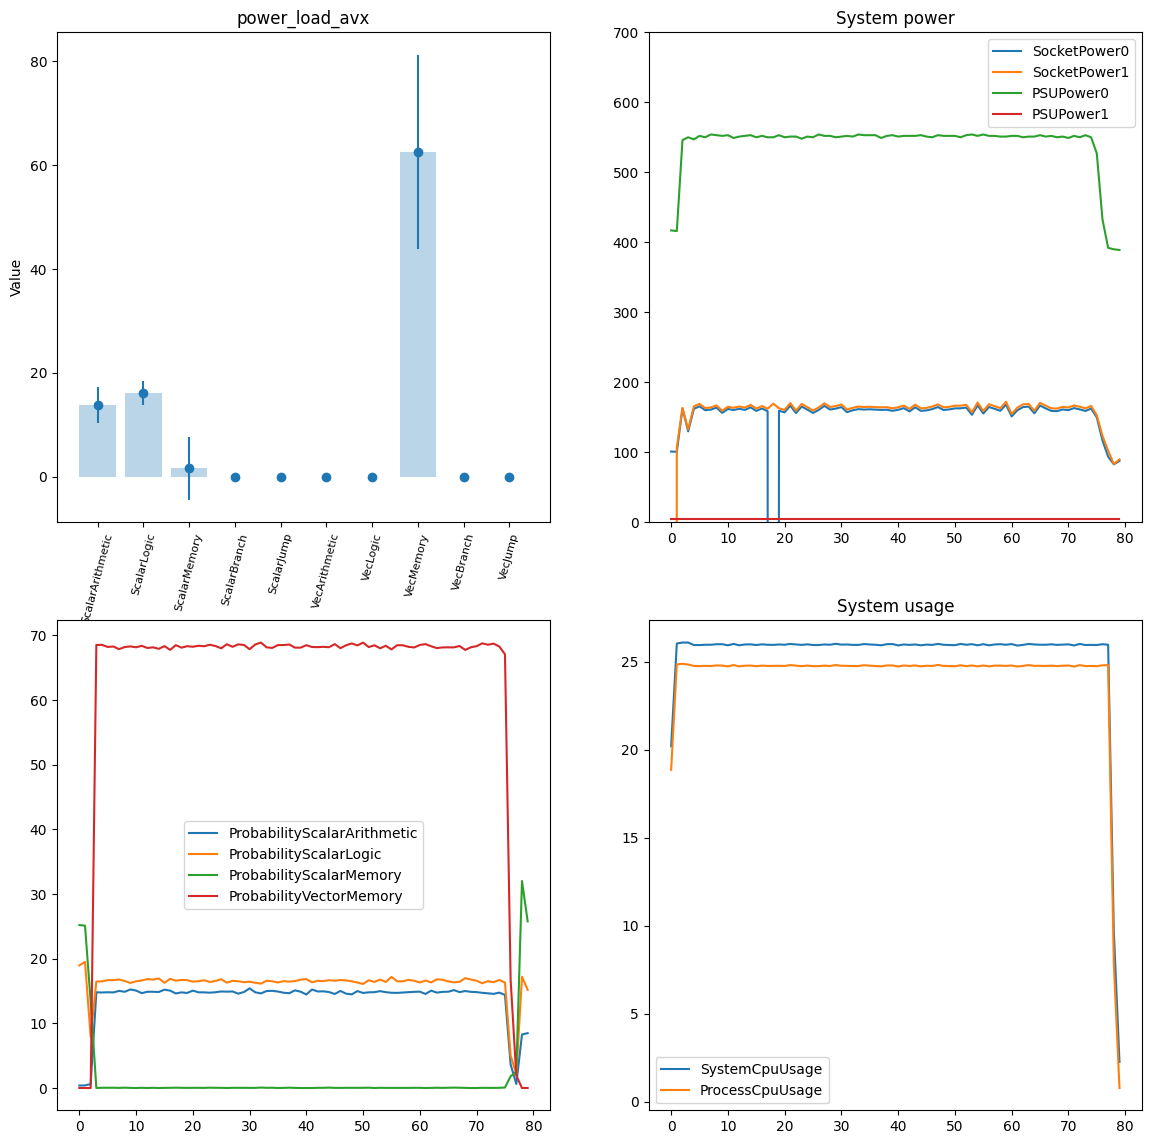

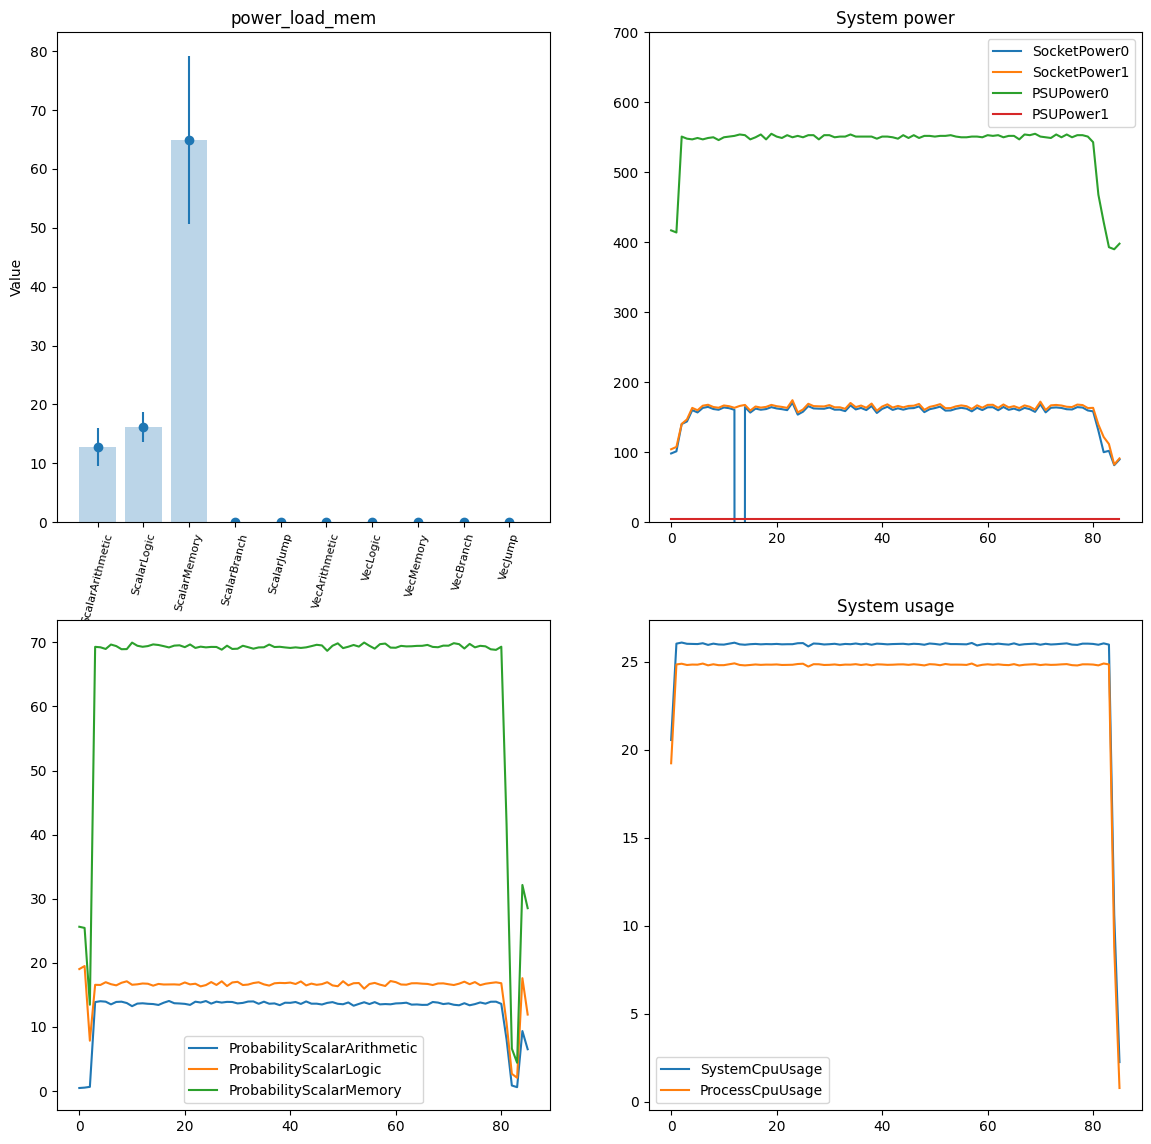

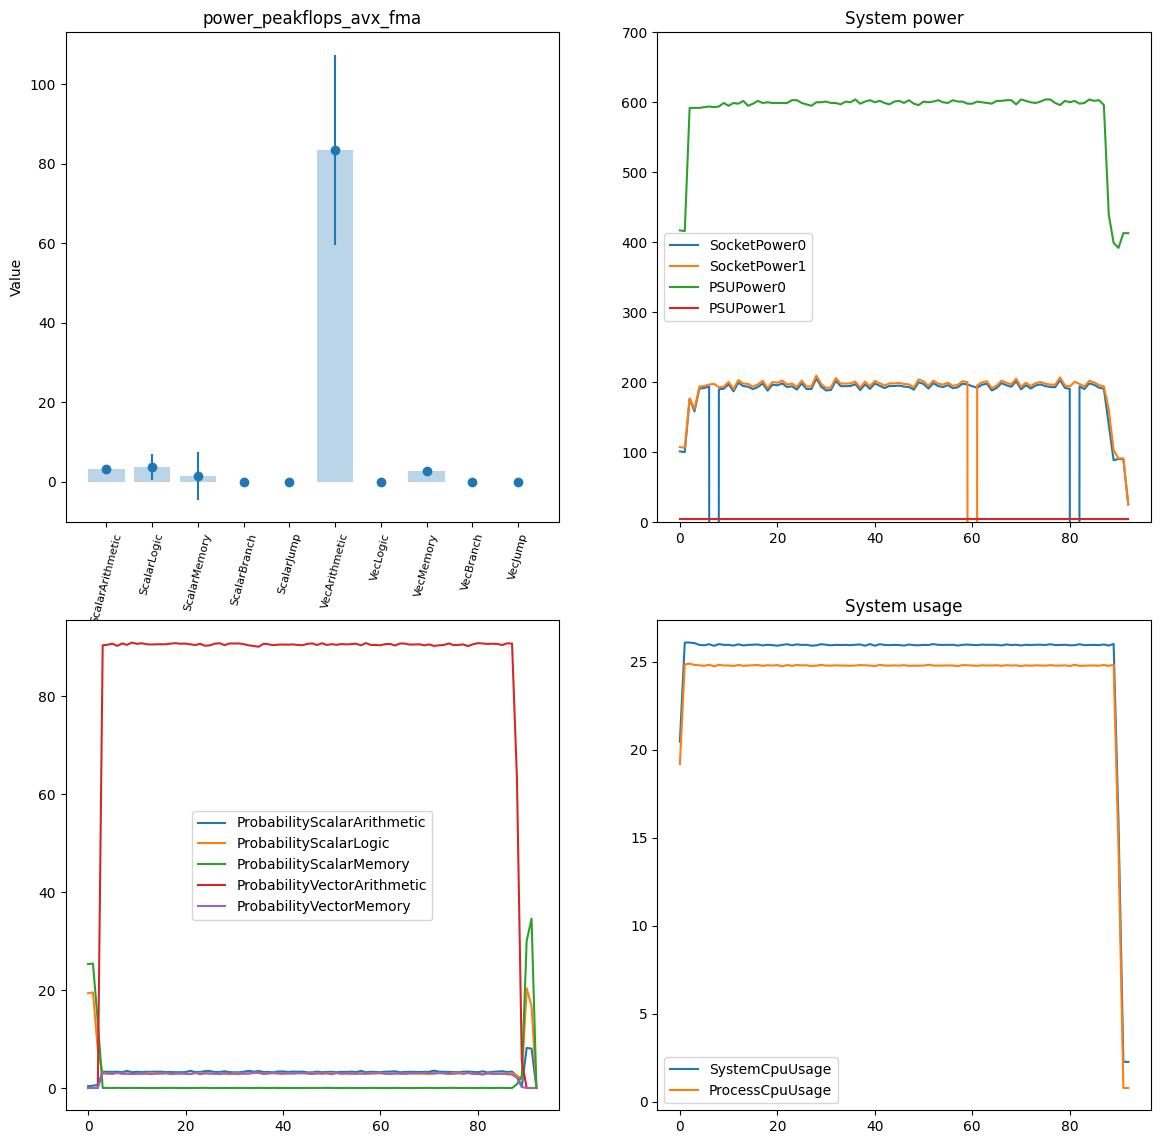

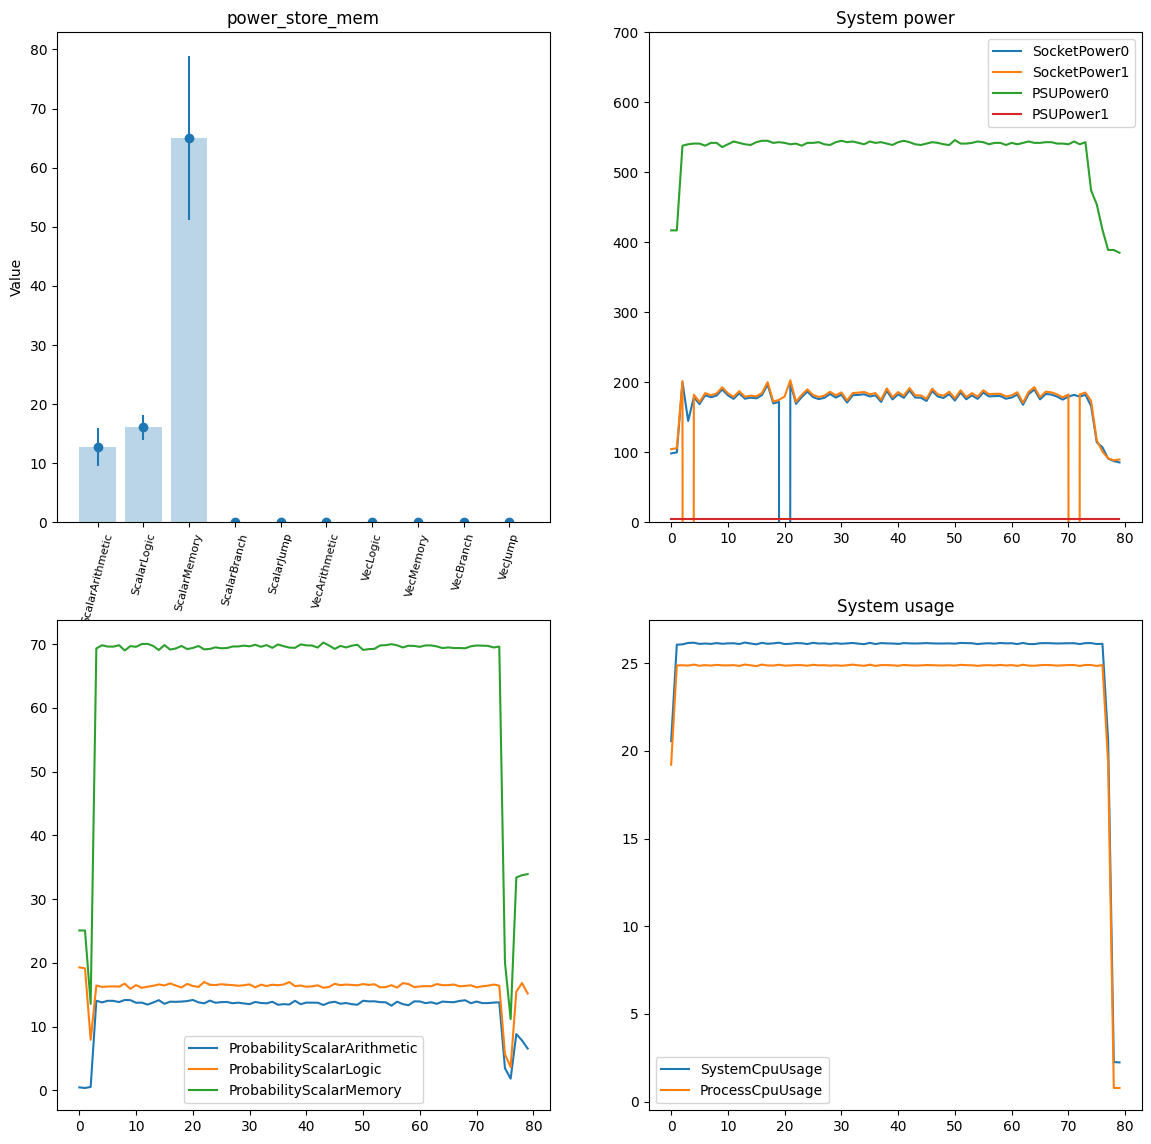

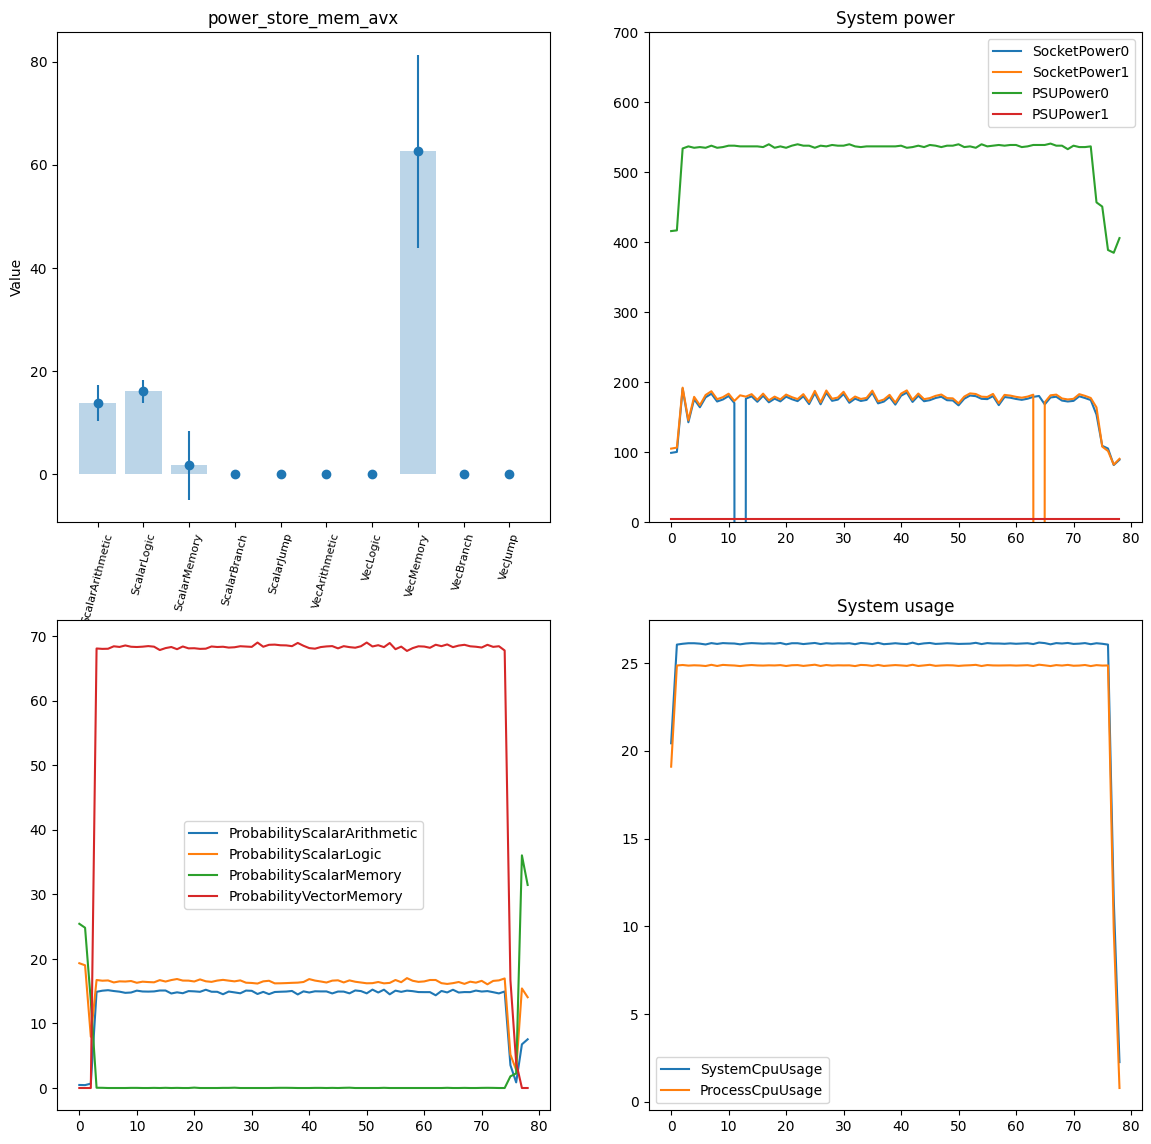

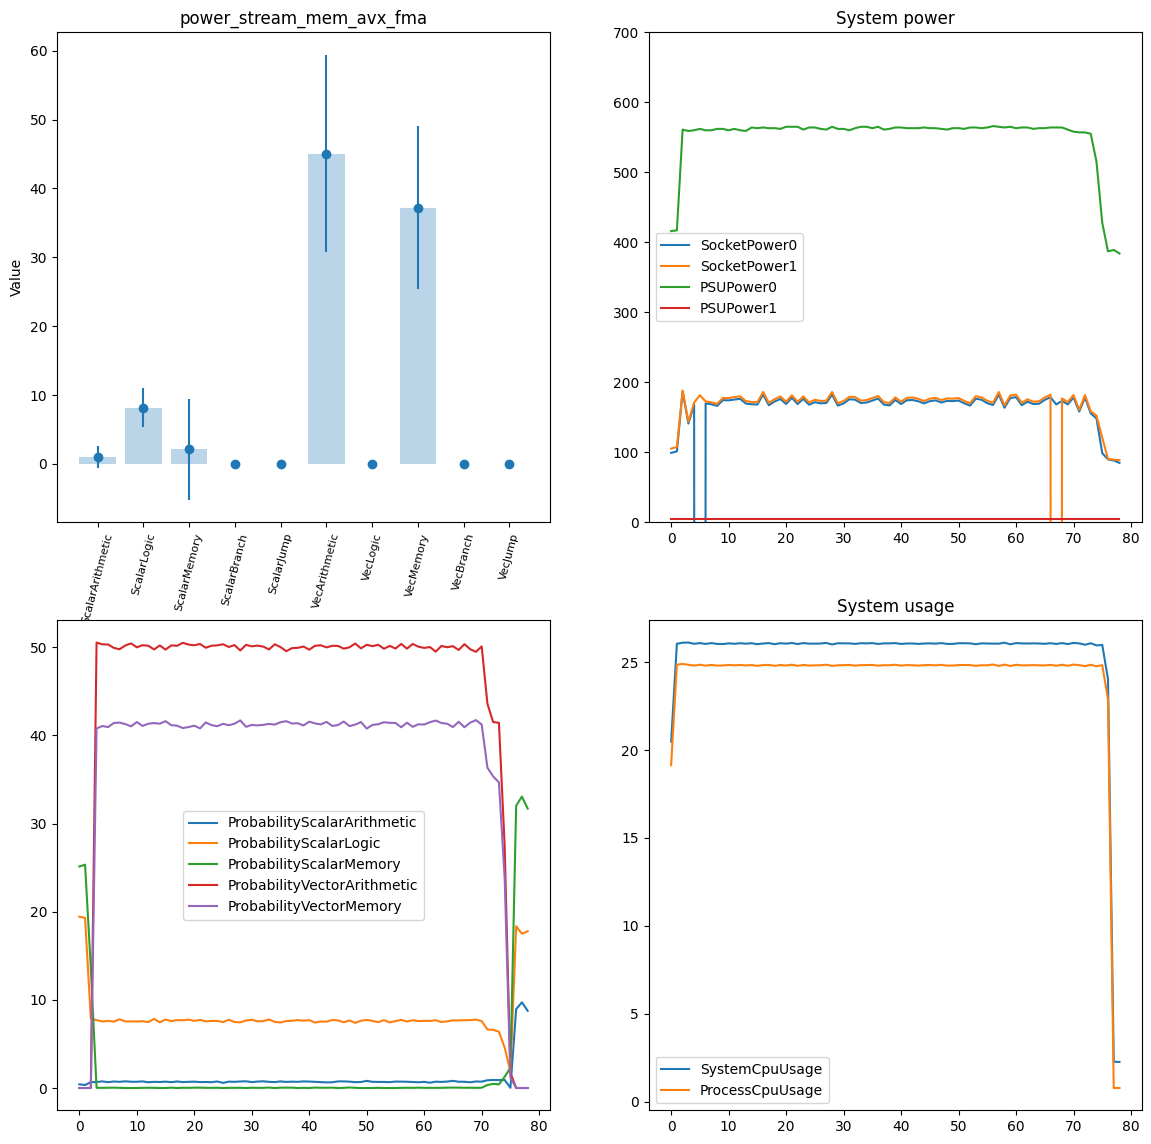

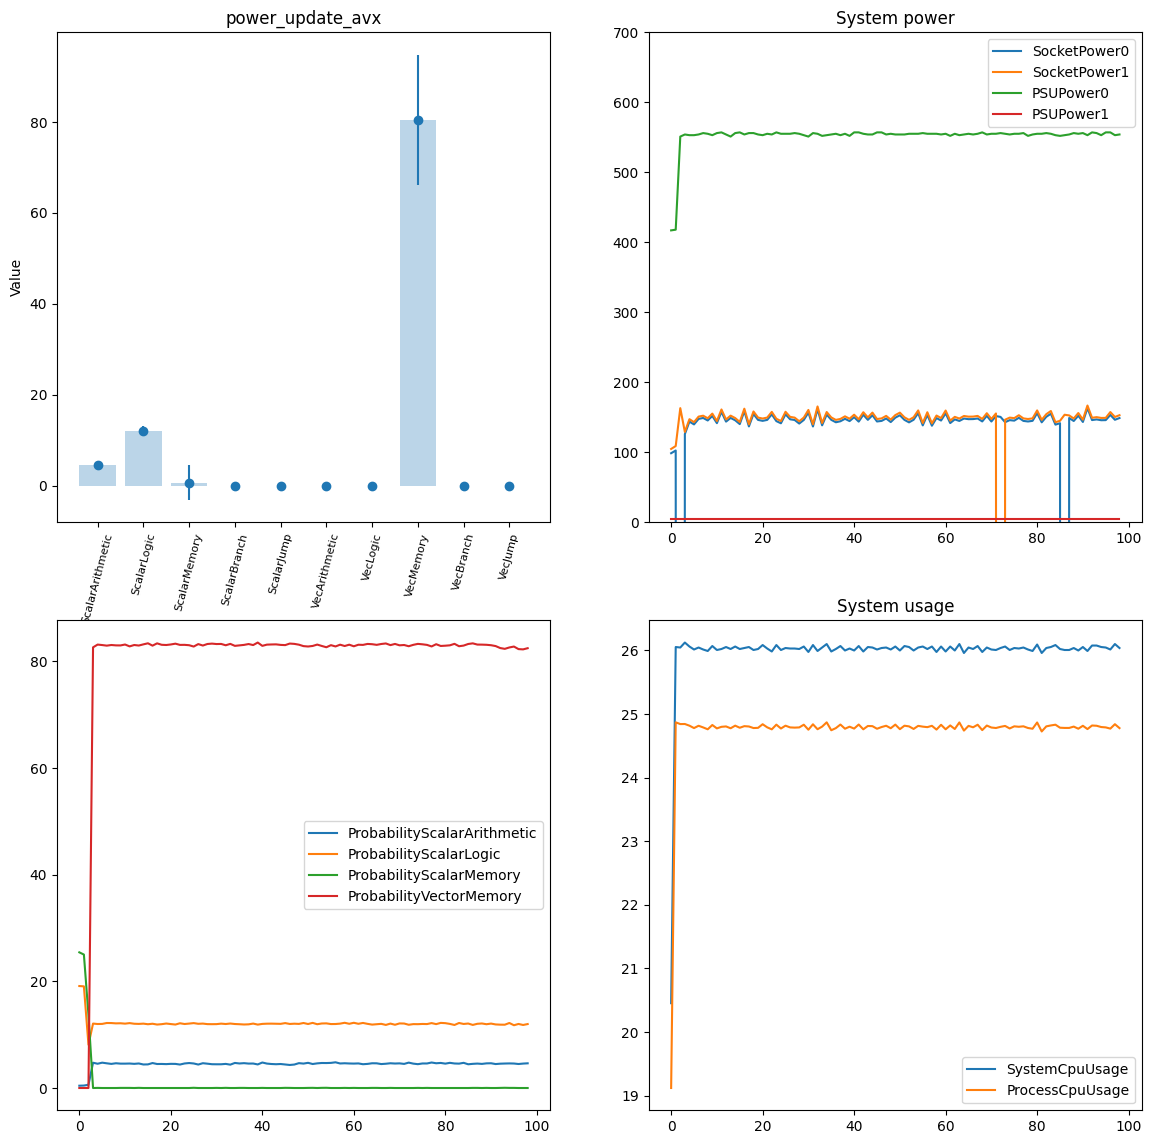

In [321]:
directory="results_32"
df_list=list()
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        try:
            df = pd.read_csv(os.path.join(directory, filename))
            df_list.append(df)
            print(f"Opened file: {filename}")
            #print(df.head())  # prints the first 5 rows of each CSV file
            plot(df,os.path.basename(filename).split(".")[0])
        except Exception as e:
            print(e)

In [322]:
df = pd.concat(df_list)

In [323]:
df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]

In [324]:
import numpy as np
from scipy.optimize import nnls

In [325]:
independent_variables=[ #"SocketPower0","SocketPower1","ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump",	"SystemCpuUsage"]#, 	"ProcessCpuUsage"]

In [326]:
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]

In [327]:
A=df[independent_variables].to_numpy()
b=np.ones((A.shape[0],1))
A=np.hstack((A,b))

coeff,error=nnls(A, df["Total_power"].to_numpy())
intercept=coeff[-1]

print(f"Residual {error}, intercept {intercept}")

Residual 547.7020702615995, intercept 325.3619095105698


Text(0.5, 0, 'Predicted value')

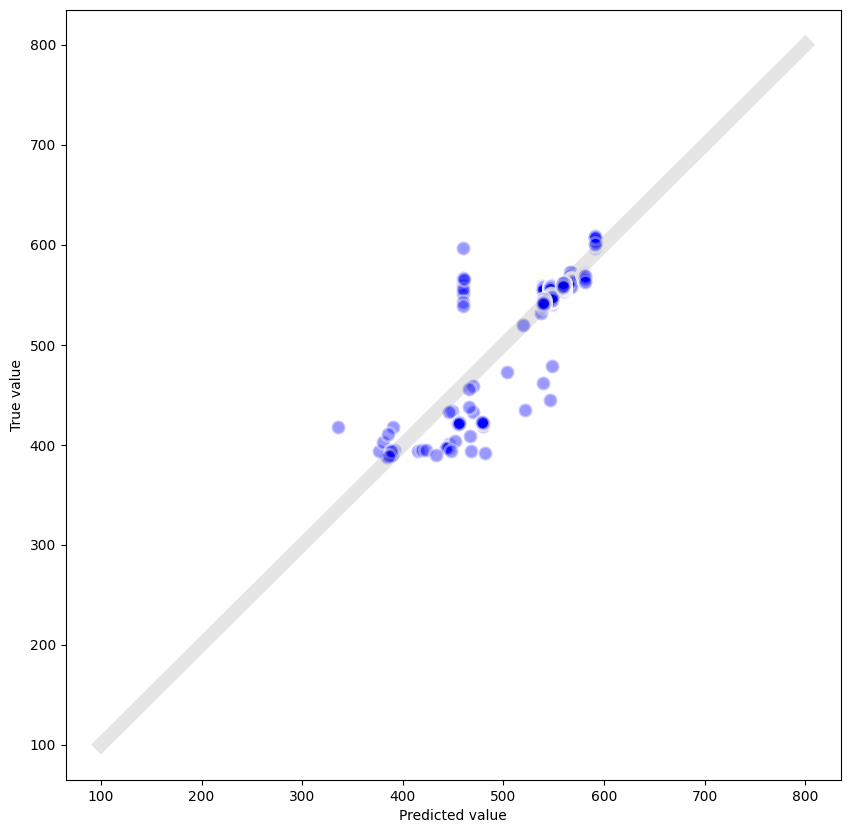

In [328]:
prediction=list()
for row in df[independent_variables].to_numpy():
    prediction.append(row@coeff[:-1] + intercept)

plt.figure(figsize=(10,10))
plt.plot(prediction,df["Total_power"], 'bo', 
         markersize=10, 
         alpha=0.4,
         fillstyle='full',
         markeredgecolor='white',
         markeredgewidth=2)

plt.plot([100,800],[100,800], '-k', linewidth=10, alpha=0.1, label='Bisector Line')
plt.ylabel("True value")
plt.xlabel("Predicted value")

In [329]:
coeff

array([1.08468138e-01, 1.54604684e+00, 0.00000000e+00, 0.00000000e+00,
       1.63986120e+00, 0.00000000e+00, 1.44858615e+00, 0.00000000e+00,
       0.00000000e+00, 4.33776025e+00, 3.25361910e+02])

In [405]:
def normalize(df):
    percentages=independent_variables=["ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]
    df[percentages]=df[percentages]/100
    df["SystemCpuUsage"]=df["SystemCpuUsage"]/128
    df["ProcessCpuUsage"]=df["ProcessCpuUsage"]/128
    return df

In [406]:
directory_list=["results_32","results_64","results_fan"]

df_list=list()
for directory in directory_list:
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            try:
                df = pd.read_csv(os.path.join(directory, filename))
                df_list.append(df)
                print(f"Opened file: {filename}")
                #print(df.head())  # prints the first 5 rows of each CSV file
                #plot(df,os.path.basename(filename).split(".")[0])
            except Exception as e:
                print(e)


df = pd.concat(df_list)
df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
TDP=280
df = normalize(df)

Opened file: power_copy.csv
Opened file: power_copy_mem.csv
Opened file: power_copy_mem_avx.csv
Opened file: power_daxpy_mem_avx_fma.csv
Opened file: power_load_avx.csv
Opened file: power_load_mem.csv
Opened file: power_peakflops_avx_fma.csv
Opened file: power_store_mem.csv
Opened file: power_store_mem_avx.csv
Opened file: power_stream_mem_avx_fma.csv
Opened file: power_update_avx.csv
Opened file: power_copy.csv
Opened file: power_copy_mem.csv
Opened file: power_copy_mem_avx.csv
Opened file: power_daxpy_mem_avx_fma.csv
Opened file: power_load_avx.csv
Opened file: power_load_mem.csv
Opened file: power_peakflops_avx_fma.csv
Opened file: power_store_mem.csv
Opened file: power_store_mem_avx.csv
Opened file: power_stream_mem_avx_fma.csv
Opened file: power_update_avx.csv
Opened file: power_copy.csv
Opened file: power_copy_mem.csv
Opened file: power_copy_mem_avx.csv
Opened file: power_daxpy_mem_avx_fma.csv
Opened file: power_load_avx.csv
Opened file: power_load_mem.csv
Opened file: power_peak

In [407]:
independent_variables=[ "ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]

In [408]:
for var in independent_variables:
    df[var]=df[var]*df["SystemCpuUsage"]*TDP*2

In [409]:
A=df[independent_variables].to_numpy()
b=np.ones((A.shape[0],1))
A=np.hstack((A,b))

coeff,error=nnls(A, df["Total_power"].to_numpy(), maxiter=1000,atol=max(A.shape) * np.linalg.norm(A, 1) * np.spacing(1.))
intercept=coeff[-1]

print(f"Residual {error}, intercept {intercept}")
print(coeff)

Residual 1745.2114915577388, intercept 412.2597192585005
[  0.90857685   0.43983022   0.94435224   0.           0.
   1.15122924   0.           0.93834955   0.           0.
 412.25971926]


Text(0.5, 0, 'Predicted value')

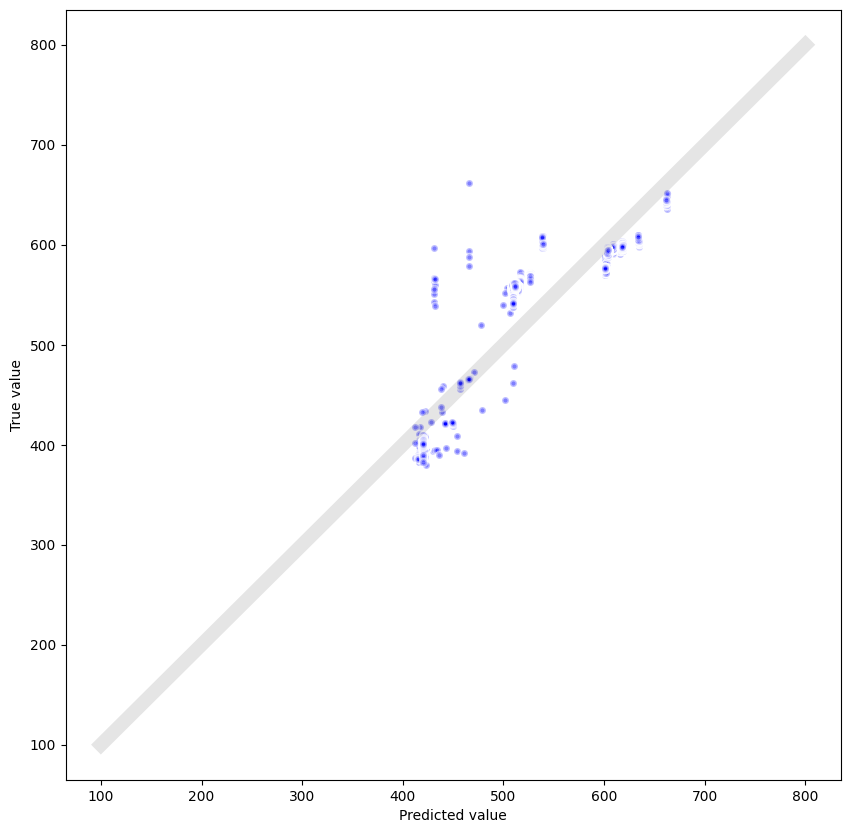

In [410]:
prediction=list()

for row in df[independent_variables_cpu].to_numpy():
    prediction.append(row@coeff[:-1] + intercept)

plt.figure(figsize=(10,10))
plt.plot(prediction,df["Total_power"], 'bo', 
         markersize=5, 
         alpha=0.5,
         fillstyle='full',
         markeredgecolor='white',
         markeredgewidth=2)

plt.plot([100,800],[100,800], '-k', linewidth=10, alpha=0.1, label='Bisector Line')
plt.ylabel("True value")
plt.xlabel("Predicted value")

Text(0.5, 0, 'Socket power predicted')

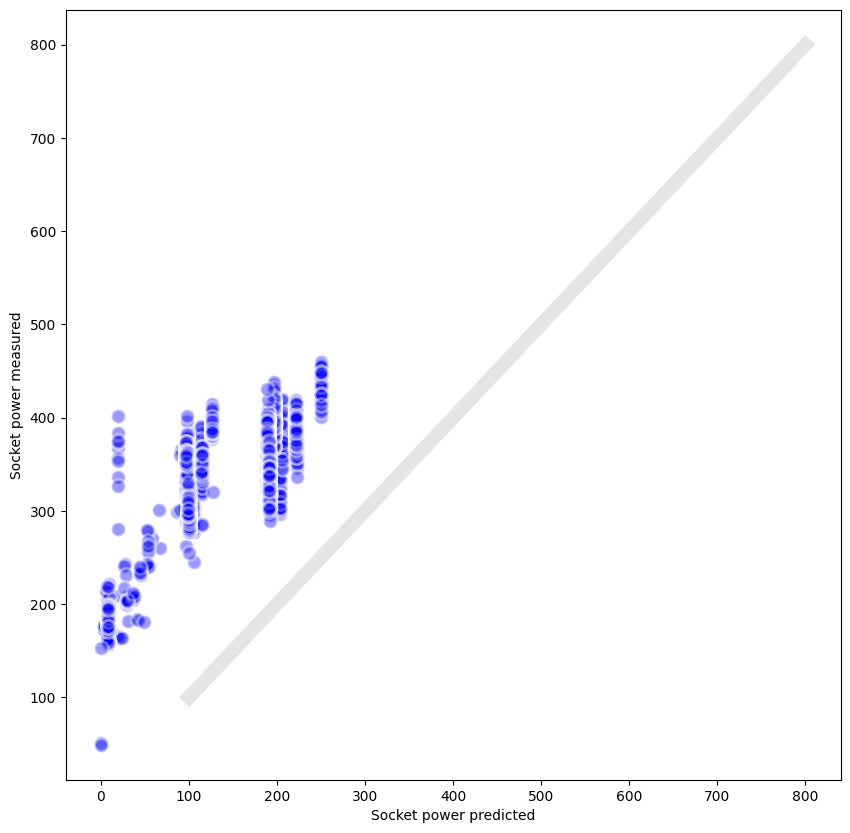

In [398]:
prediction=list()

for row in df[independent_variables_cpu].to_numpy():
    prediction.append(row@coeff[:-1])

plt.figure(figsize=(10,10))
plt.plot(prediction,df["SocketPower0"]+df["SocketPower1"], 'bo', 
         markersize=10, 
         alpha=0.4,
         fillstyle='full',
         markeredgecolor='white',
         markeredgewidth=2)

plt.plot([100,800],[100,800], '-k', linewidth=10, alpha=0.1, label='Bisector Line')
plt.ylabel("Socket power measured")
plt.xlabel("Socket power predicted")

In [ ]:



def plot(df,name):
    # Your data
    column_name_probability = ['ProbabilityScalarArithmetic',
        'ProbabilityScalarLogic',
        'ProbabilityScalarMemory',
        'ProbabilityScalarBranch',
        'ProbabilityScalarJump',
        'ProbabilityVectorArithmetic',
        'ProbabilityVectorLogic',
        'ProbabilityVectorMemory',
        'ProbabilityVectorBranch',
        'ProbabilityVectorJump']
    
    column_name_probability_labels = ['ScalarArithmetic',
        'ScalarLogic',
        'ScalarMemory',
        'ScalarBranch',
        'ScalarJump',
        'VecArithmetic',
        'VecLogic',
        'VecMemory',
        'VecBranch',
        'VecJump']
    plt.figure(figsize=(14,14))

    plt.subplot(2, 2, 1)

    plt.title(name)
    x=range(0,len(column_name_probability))
    
    plt.bar(x=x,height=df[column_name_probability].mean(),alpha=0.3)
    plt.errorbar(x,df[column_name_probability].mean(),yerr=df[column_name_probability].std(), fmt='o')
    #.plot(kind='bar', width=0.8) # Plot bar chart
    #plt.title("ksad") # Set title as column name
    #plt.xlabel(column) # Set x-axis label as column name
    plt.xticks(ticks=x,labels=column_name_probability_labels,rotation=90-15,fontsize=8)
    #plt.xticks(ticks=range(0,len(column_name)),labels=column,rotation=45)
    plt.ylabel('Value') # Set y-axis label as 'Value'
    column_name=["SocketPower0", "SocketPower1","PSUPower0","PSUPower1"]
    plt.subplot(2, 2, 2)
    plt.title("System power")
    _ = plt.plot(df[column_name],label=column_name)
    plt.ylim([0,700])
    plt.legend()
    plt.subplot(2, 2, 3)
    filtered_df = df[column_name_probability].loc[:, df[column_name_probability].mean() > 0]
    plt.plot(filtered_df,label=filtered_df.columns.tolist())
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.title("System usage")
    plt.plot(df[["SystemCpuUsage" ,"ProcessCpuUsage"]],label=["SystemCpuUsage" ,"ProcessCpuUsage"])
    plt.legend()
    plt.savefig(f"{name}.png")